# ECG Data Analysis - WFDB Format

## Dataset Overview
- **Format:** WFDB (WaveForm DataBase)
- **Records:** 659 ECG recordings
- **Type:** 12-lead ECG
- **Sampling Rate:** 500 Hz
- **Duration:** 10 seconds per record
- **Leads:** I, II, III, aVR, aVF, aVL, V1, V2, V3, V4, V5, V6

In [10]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.signal import butter, filtfilt, iirnotch
import copy


## 2. Define File Paths

Set up paths data files

In [11]:
# Define paths
UPLOADS_DIR = Path("../mimic-iv-ecg-demo-data")

# Verify paths exist
print(f"Uploads directory exists: {UPLOADS_DIR.exists()}")

Uploads directory exists: True


## 3. Load and Explore the Record Index

Examine record list to see what data we have available

In [12]:
# Load the record list
record_list = pd.read_csv(UPLOADS_DIR / "record_list.csv")

print(f"Total number of ECG records: {len(record_list)}")
print(f"\nNumber of unique patients: {record_list['subject_id'].nunique()}")
print(f"\nFirst 10 records:")
record_list.head(10)

Total number of ECG records: 659

Number of unique patients: 92

First 10 records:


,subject_id,study_id,file_name,ecg_time,path
0,10000032,107143276,107143276,2180-07-23 08:44:24,files/p10000032/s107143276/107143276
1,10000032,102511170,102511170,2180-08-06 09:07:36,files/p10000032/s102511170/102511170
2,10000032,100780919,100780919,2180-07-23 09:54:32,files/p10000032/s100780919/100780919
3,10001217,105362569,105362569,2157-11-18 18:26:02,files/p10001217/s105362569/105362569
4,10001217,102172660,102172660,2157-11-20 09:08:38,files/p10001217/s102172660/102172660
5,10001725,102147240,102147240,2110-06-08 14:39:12,files/p10001725/s102147240/102147240
6,10002428,104430624,104430624,2156-04-20 09:31:52,files/p10002428/s104430624/104430624
7,10002428,102144047,102144047,2152-12-13 14:34:52,files/p10002428/s102144047/102144047
8,10002428,106959793,106959793,2156-04-14 08:21:12,files/p10002428/s106959793/106959793
9,10002428,106183809,106183809,2156-04-30 20:50:58,files/p10002428/s106183809/106183809


In [13]:
# Get basic statistics
print("Records per patient:")
records_per_patient = record_list.groupby('subject_id').size()
print(f"Mean: {records_per_patient.mean():.1f}")
print(f"Median: {records_per_patient.median():.0f}")
print(f"Max: {records_per_patient.max()}")
print(f"Min: {records_per_patient.min()}")

Records per patient:
Mean: 7.2
Median: 5
Max: 52
Min: 1


In [14]:
# Check to see if study_id doesn't match with file_name to understand file structure
record_list[record_list['study_id'] != record_list['file_name'] ]

,subject_id,study_id,file_name,ecg_time,path


In [15]:
# # Round ecg_time to combine data
# # ONLY SPECIFIC TO THIS PROBLEM WHERE THE STUDY_ID DONT MATCH BUT THE ECG_TIME IS CLOSE (0s MILSECONDS)
# record_list['ecg_time'] = pd.to_datetime(
#     record_list['ecg_time'], 
#     errors='coerce'
# ).dt.floor('min')

# record_list.head(10)

In [16]:
# record_list['ecg_time'].dtype

## 4. Load, Explore, Concat Machine Measurements and Reports

In [17]:
report_df = pd.read_csv(UPLOADS_DIR / 'machine_measurements.csv')
report_df.head(5)

/var/folders/bn/28hly9dd0z36556zl0gx44v80000gn/T/ipykernel_35555/452130160.py:1: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  report_df = pd.read_csv(UPLOADS_DIR / 'machine_measurements.csv')


,subject_id,study_id,cart_id,ecg_time,report_0,report_1,report_2,report_3,report_4,report_5,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,10000032,40689238,6848296,2180-07-23 08:44:00,Sinus rhythm,Possible right atrial abnormality,NaN,Borderline ECG,NaN,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,10000032,44458630,6848296,2180-07-23 09:54:00,Sinus rhythm,Possible right atrial abnormality,NaN,Borderline ECG,NaN,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,10000032,49036311,6376932,2180-08-06 09:07:00,Sinus tachycardia,NaN,Normal ECG except for rate,NaN,NaN,NaN,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,10000117,45090959,6214760,2181-03-04 17:14:00,Sinus rhythm,NaN,Normal ECG,NaN,NaN,NaN,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,10000117,48446569,6632385,2183-09-18 13:52:00,Sinus rhythm,NaN,NaN,NaN,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77


In [18]:
# report_df['ecg_time'] = pd.to_datetime(
#     record_list['ecg_time'], 
#     errors='coerce'
# )

# report_df

In [19]:
# merged_df = (pd.merge(record_list, report_df, how="inner", on=['']))
# merged_df

In [20]:
print(report_df['bandwidth'].unique())
print(report_df['filtering'].unique())

['0.005-150 Hz' '0.0005-150 Hz' '0.05-150 Hz']
['60 Hz notch Baseline filter' '<not specified>' 'Baseline filter'
 '50 Hz notch Baseline filter']


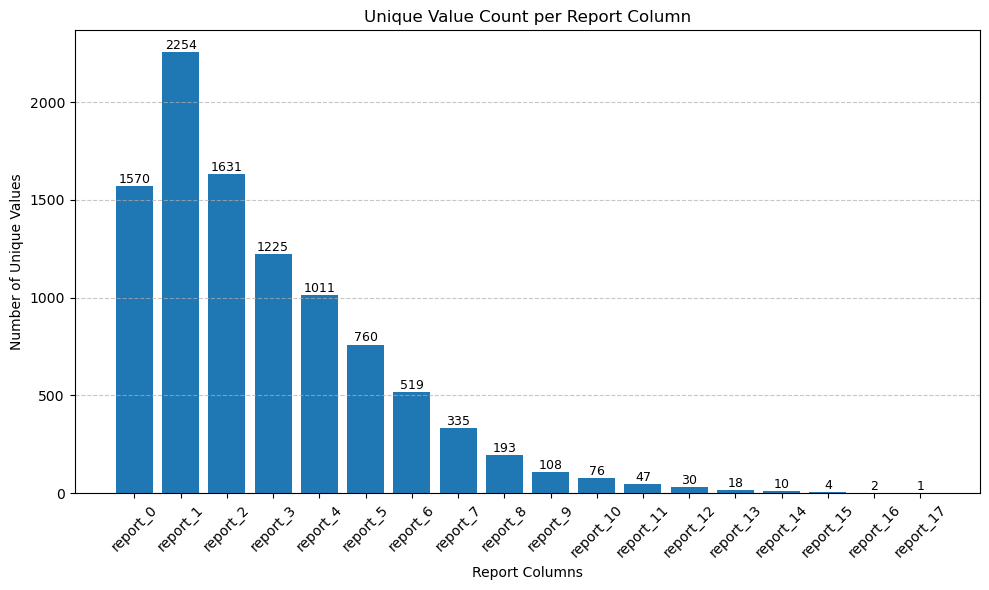

In [21]:
report_cols = [f'report_{i}' for i in range(18)]
unique_counts = [report_df[col].nunique() for col in report_cols]

plt.figure(figsize=(10, 6))
bars = plt.bar(report_cols, unique_counts)

plt.title('Unique Value Count per Report Column')
plt.xlabel('Report Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, 
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

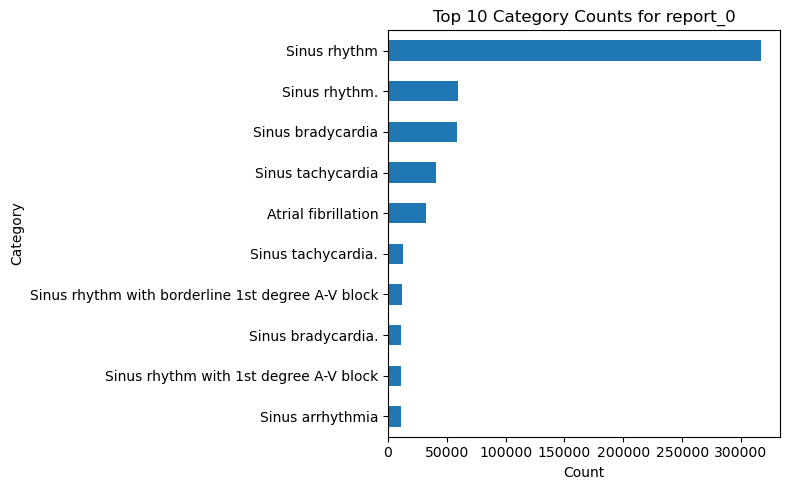

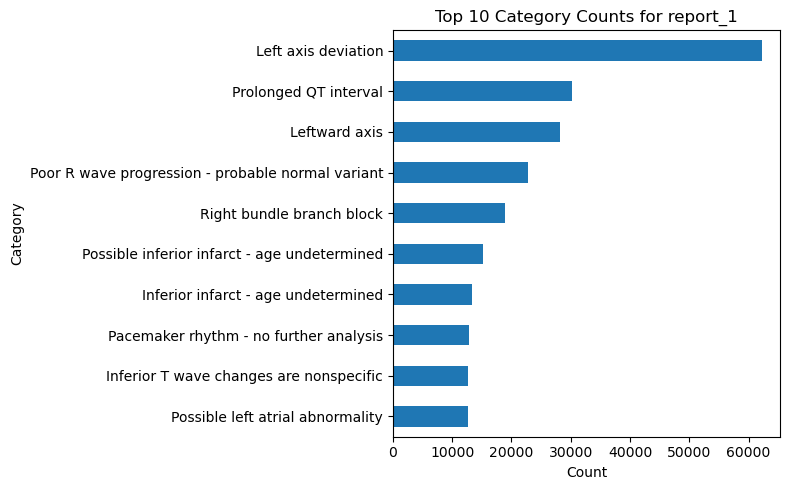

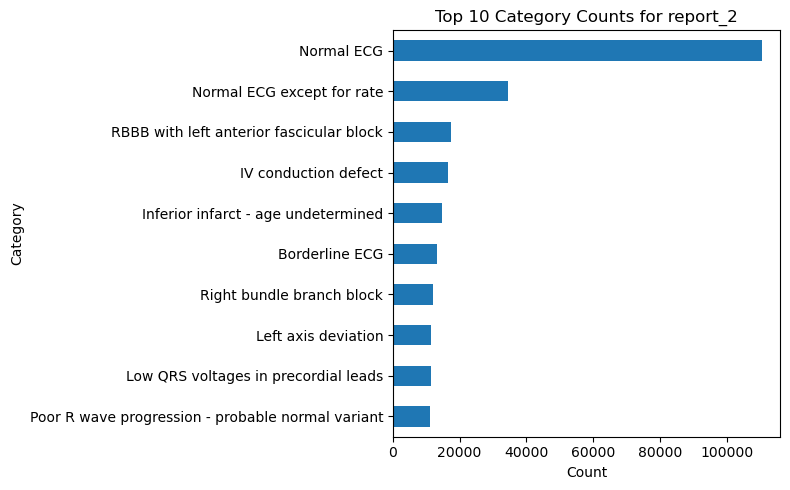

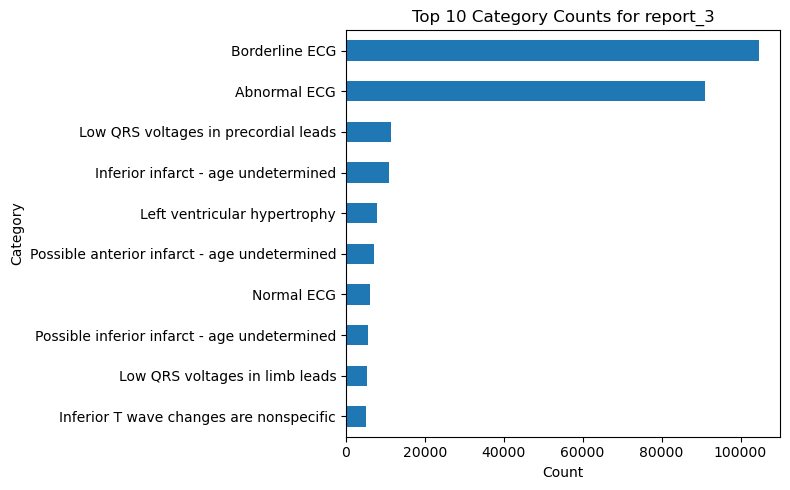

In [22]:
# Loop over the first three report columns
for i in range(4):
    col = f'report_{i}'
    counts = report_df[col].value_counts().sort_values(ascending=False)[:10]
    
    plt.figure(figsize=(8, 5))
    counts.plot(kind='barh')
    plt.title(f'Top 10 Category Counts for {col}')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

## 4. Reading a Single ECG Record

Read one ECG record and examine its structure

In [23]:
# Select first record to analyze
file_path = record_list['path'][0]
print(file_path)

# Read the record
record_path = UPLOADS_DIR / file_path
record = wfdb.rdrecord(str(record_path))

print("Record loaded successfully!")
print(f"Record name: {record.record_name}")

files/p10000032/s107143276/107143276
Record loaded successfully!
Record name: 107143276


## 5. Explore Record's Metadata

Examine metadata stored in the header file

In [24]:
# Display metadata
print("="*60)
print("ECG RECORD INFORMATION")
print("="*60)
print(f"Record name: {record.record_name}")
print(f"Sampling frequency: {record.fs} Hz")
print(f"Duration: {record.sig_len / record.fs:.2f} seconds")
print(f"Number of samples: {record.sig_len}")
print(f"Number of signals (leads): {record.n_sig}")
print(f"\nSignal names: {', '.join(record.sig_name)}")
print(f"Units: {', '.join(record.units)}")

if hasattr(record, 'comments') and record.comments:
    print(f"\nComments:")
    for comment in record.comments:
        print(f"  {comment}")

ECG RECORD INFORMATION
Record name: 107143276
Sampling frequency: 500 Hz
Duration: 10.00 seconds
Number of samples: 5000
Number of signals (leads): 12

Signal names: I, II, III, aVR, aVF, aVL, V1, V2, V3, V4, V5, V6
Units: mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV

Comments:
  <subject_id>: 10000032


## 6. Access Subject's Signal Data

For subject id 10000032

In [25]:
# Access the signal data
signals = record.p_signal

print(f"Signal data shape: {signals.shape}")
print(f"  - Rows (samples): {signals.shape[0]}")
print(f"  - Columns (leads): {signals.shape[1]}")
print(f"Data type: {signals.dtype}")

# Show first few samples
df_preview = pd.DataFrame(signals, columns=record.sig_name)
df_preview

Signal data shape: (5000, 12)
  - Rows (samples): 5000
  - Columns (leads): 12
Data type: float64


,I,II,III,aVR,aVF,aVL,V1,V2,V3,V4,V5,V6
0,-0.155,0.01,0.150,0.070,0.075,-0.140,0.040,0.040,0.010,0.040,0.080,0.020
1,-0.170,0.01,0.165,0.075,0.085,-0.160,0.055,0.055,0.020,0.030,0.080,0.020
2,-0.170,0.00,0.155,0.080,0.075,-0.155,0.060,0.055,0.030,0.025,0.080,0.010
3,-0.170,0.00,0.155,0.080,0.075,-0.155,0.055,0.055,0.030,0.020,0.080,0.010
4,-0.170,0.00,0.155,0.080,0.075,-0.155,0.050,0.055,0.030,0.020,0.080,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.050,0.01,0.045,0.015,0.025,-0.040,-0.005,0.010,-0.030,-0.015,-0.010,-0.190
4996,-0.045,0.01,0.040,0.015,0.020,-0.035,-0.010,0.000,-0.040,-0.020,-0.015,-0.195
4997,-0.045,0.01,0.040,0.015,0.020,-0.035,-0.020,-0.015,-0.045,-0.020,-0.020,-0.200
4998,-0.055,0.00,0.040,0.025,0.015,-0.040,-0.010,-0.015,-0.045,-0.020,-0.020,-0.200


In [26]:
df_preview.describe().T

,count,mean,std,min,25%,50%,75%,max
I,5000.0,0.009616,0.073294,-0.170,-0.045,0.0,0.06500,0.280
II,5000.0,0.035318,0.148444,-0.200,-0.055,0.0,0.08625,0.795
III,5000.0,0.010704,0.133413,-0.275,-0.075,0.0,0.08000,0.635
aVR,5000.0,-0.025098,0.095355,-0.510,-0.055,0.0,0.03500,0.130
aVF,5000.0,0.017944,0.136182,-0.235,-0.070,0.0,0.07000,0.690
aVL,5000.0,0.007176,0.078390,-0.260,-0.045,0.0,0.06500,0.205
V1,5000.0,-0.031452,0.188125,-1.040,-0.025,0.0,0.05000,0.215
V2,5000.0,0.008828,0.230525,-0.935,-0.055,0.0,0.08000,0.545
V3,5000.0,0.096462,0.311933,-0.975,-0.055,0.0,0.15000,0.975
V4,5000.0,0.107766,0.349225,-0.665,-0.060,0.0,0.12500,1.895


## 7. Visualize All 12 Leads

Plot all ECG leads on a line plot

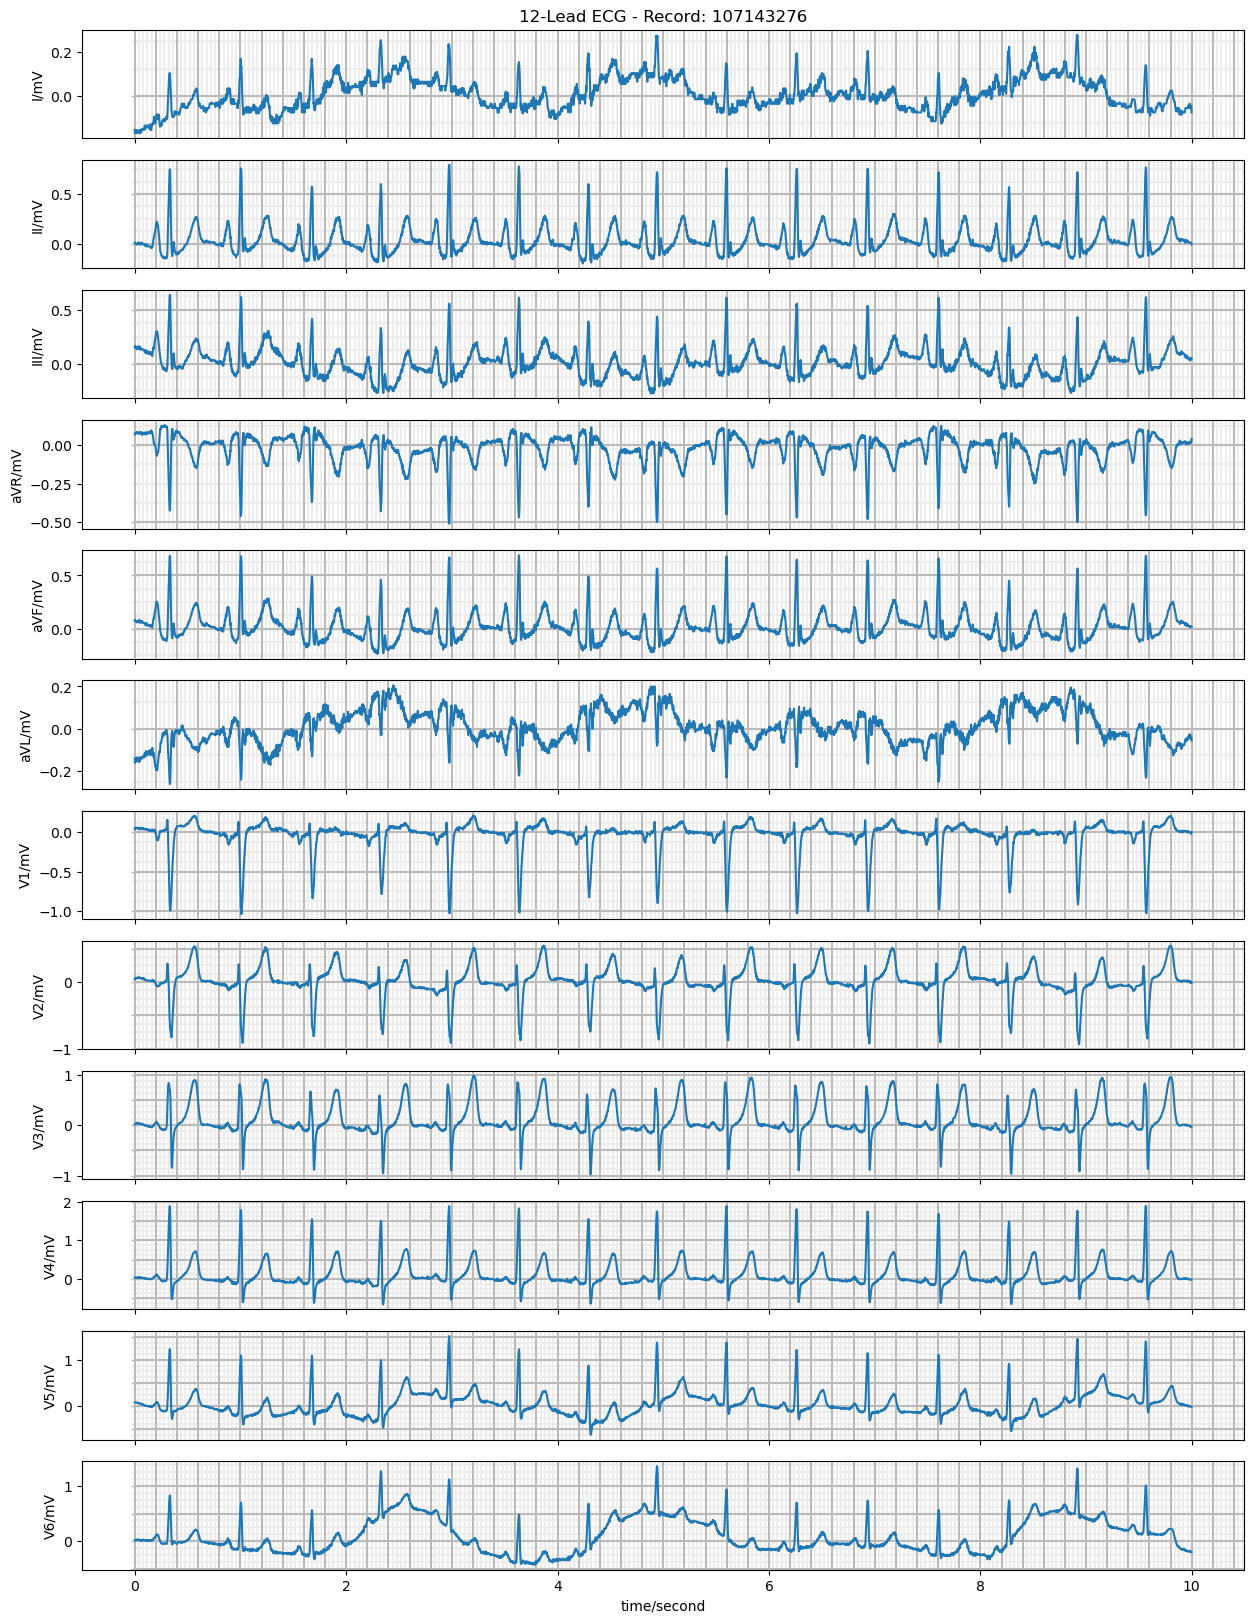

In [27]:
wfdb.plot_wfdb(record=record, figsize=(15, 20), title=f'12-Lead ECG - Record: {record.record_name}', ecg_grids='all')

# 8. Subject Distribution

Extract subject_ids and de-intified timestamps

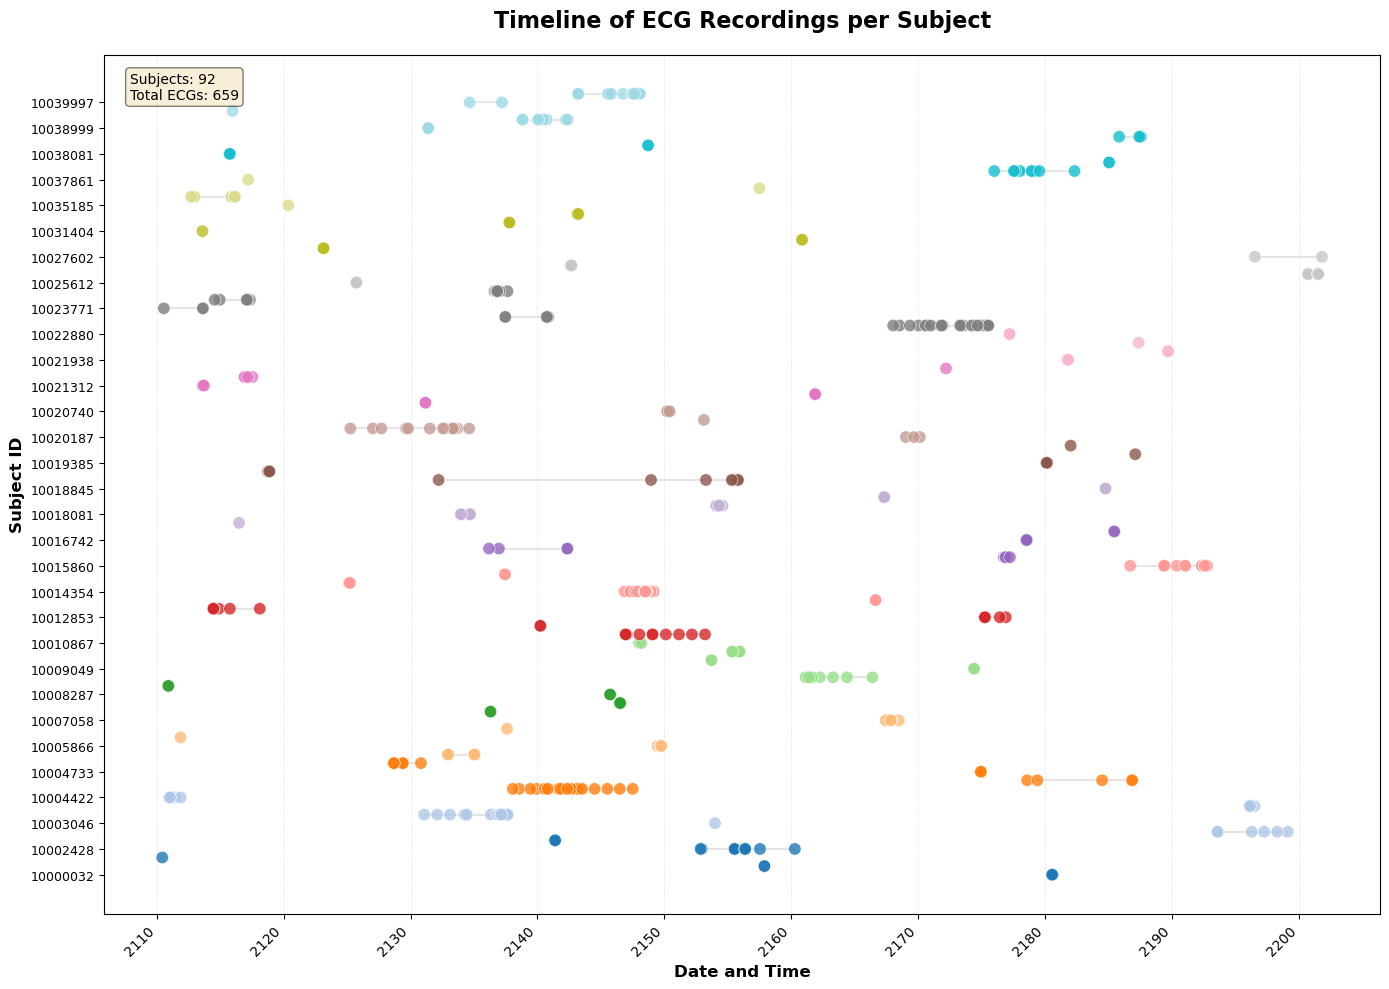

In [28]:
# Ensure ecg_time is datetime
record_list["ecg_time"] = pd.to_datetime(record_list["ecg_time"])

# Create numeric mapping for subjects (sorted by subject_id)
subject_map = {sid: i for i, sid in enumerate(sorted(record_list["subject_id"].unique()))}
record_list["subject_index"] = record_list["subject_id"].map(subject_map)

fig, ax = plt.subplots(figsize=(14, 10))
# Draw horizontal lines for each subject's timeline
for subject_id, subject_idx in subject_map.items():
    subject_data = record_list[record_list["subject_id"] == subject_id].sort_values("ecg_time")
    if len(subject_data) > 1:
        # Line spanning from first to last ECG
        ax.hlines(
            y=subject_idx,
            xmin=subject_data["ecg_time"].min(),
            xmax=subject_data["ecg_time"].max(),
            colors='lightgray',
            linewidth=1.5,
            alpha=0.6,
            zorder=1
        )

scatter = ax.scatter(
    record_list["ecg_time"],
    record_list["subject_index"],
    c=record_list["subject_index"],
    cmap="tab20",
    s=80,
    alpha=0.8,
    edgecolors='white',
    linewidth=0.5,
    zorder=2
)

ax.set_title("Timeline of ECG Recordings per Subject", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Date and Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Subject ID", fontsize=12, fontweight='bold')

sorted_subjects = sorted(subject_map.items(), key=lambda x: x[1])
subject_ids = [sid for sid, idx in sorted_subjects]
indices = [idx for sid, idx in sorted_subjects]

# Show subject IDs on y-axis (adjust step if you have many subjects)
step = max(1, len(subject_ids) // 25)
ax.set_yticks(indices[::step])
ax.set_yticklabels(subject_ids[::step], fontsize=9)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)

total_ecgs = len(record_list)
total_subjects = len(record_list["subject_id"].unique())
ax.text(0.02, 0.98, f'Subjects: {total_subjects}\nTotal ECGs: {total_ecgs}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 9. Apply Signal Filtering

Apply a bandpass filter to remove noise and baseline wander.

In [29]:
def apply_standard_filtering(record, target_lowcut=0.05, target_highcut=150):
    filtered_record = copy.deepcopy(record)
    fs = record.fs
    nyquist = 0.5 * fs
    
    # Design bandpass filter
    low = target_lowcut / nyquist
    high = target_highcut / nyquist
    b_band, a_band = butter(4, [low, high], btype='band')
    
    # Design both notch filters
    b_notch_50, a_notch_50 = iirnotch(50, Q=30, fs=fs)
    b_notch_60, a_notch_60 = iirnotch(60, Q=30, fs=fs)
    
    # Apply to all 12 leads
    for i in range(record.n_sig):
        signal = record.p_signal[:, i].copy()
        
        # Step 1: Bandpass
        signal = filtfilt(b_band, a_band, signal)
        
        # Step 2: Notch at 50 Hz
        signal = filtfilt(b_notch_50, a_notch_50, signal)
        
        # Step 3: Notch at 60 Hz
        signal = filtfilt(b_notch_60, a_notch_60, signal)
        
        filtered_record.p_signal[:, i] = signal
    return filtered_record

cleaned_record = apply_standard_filtering(record)


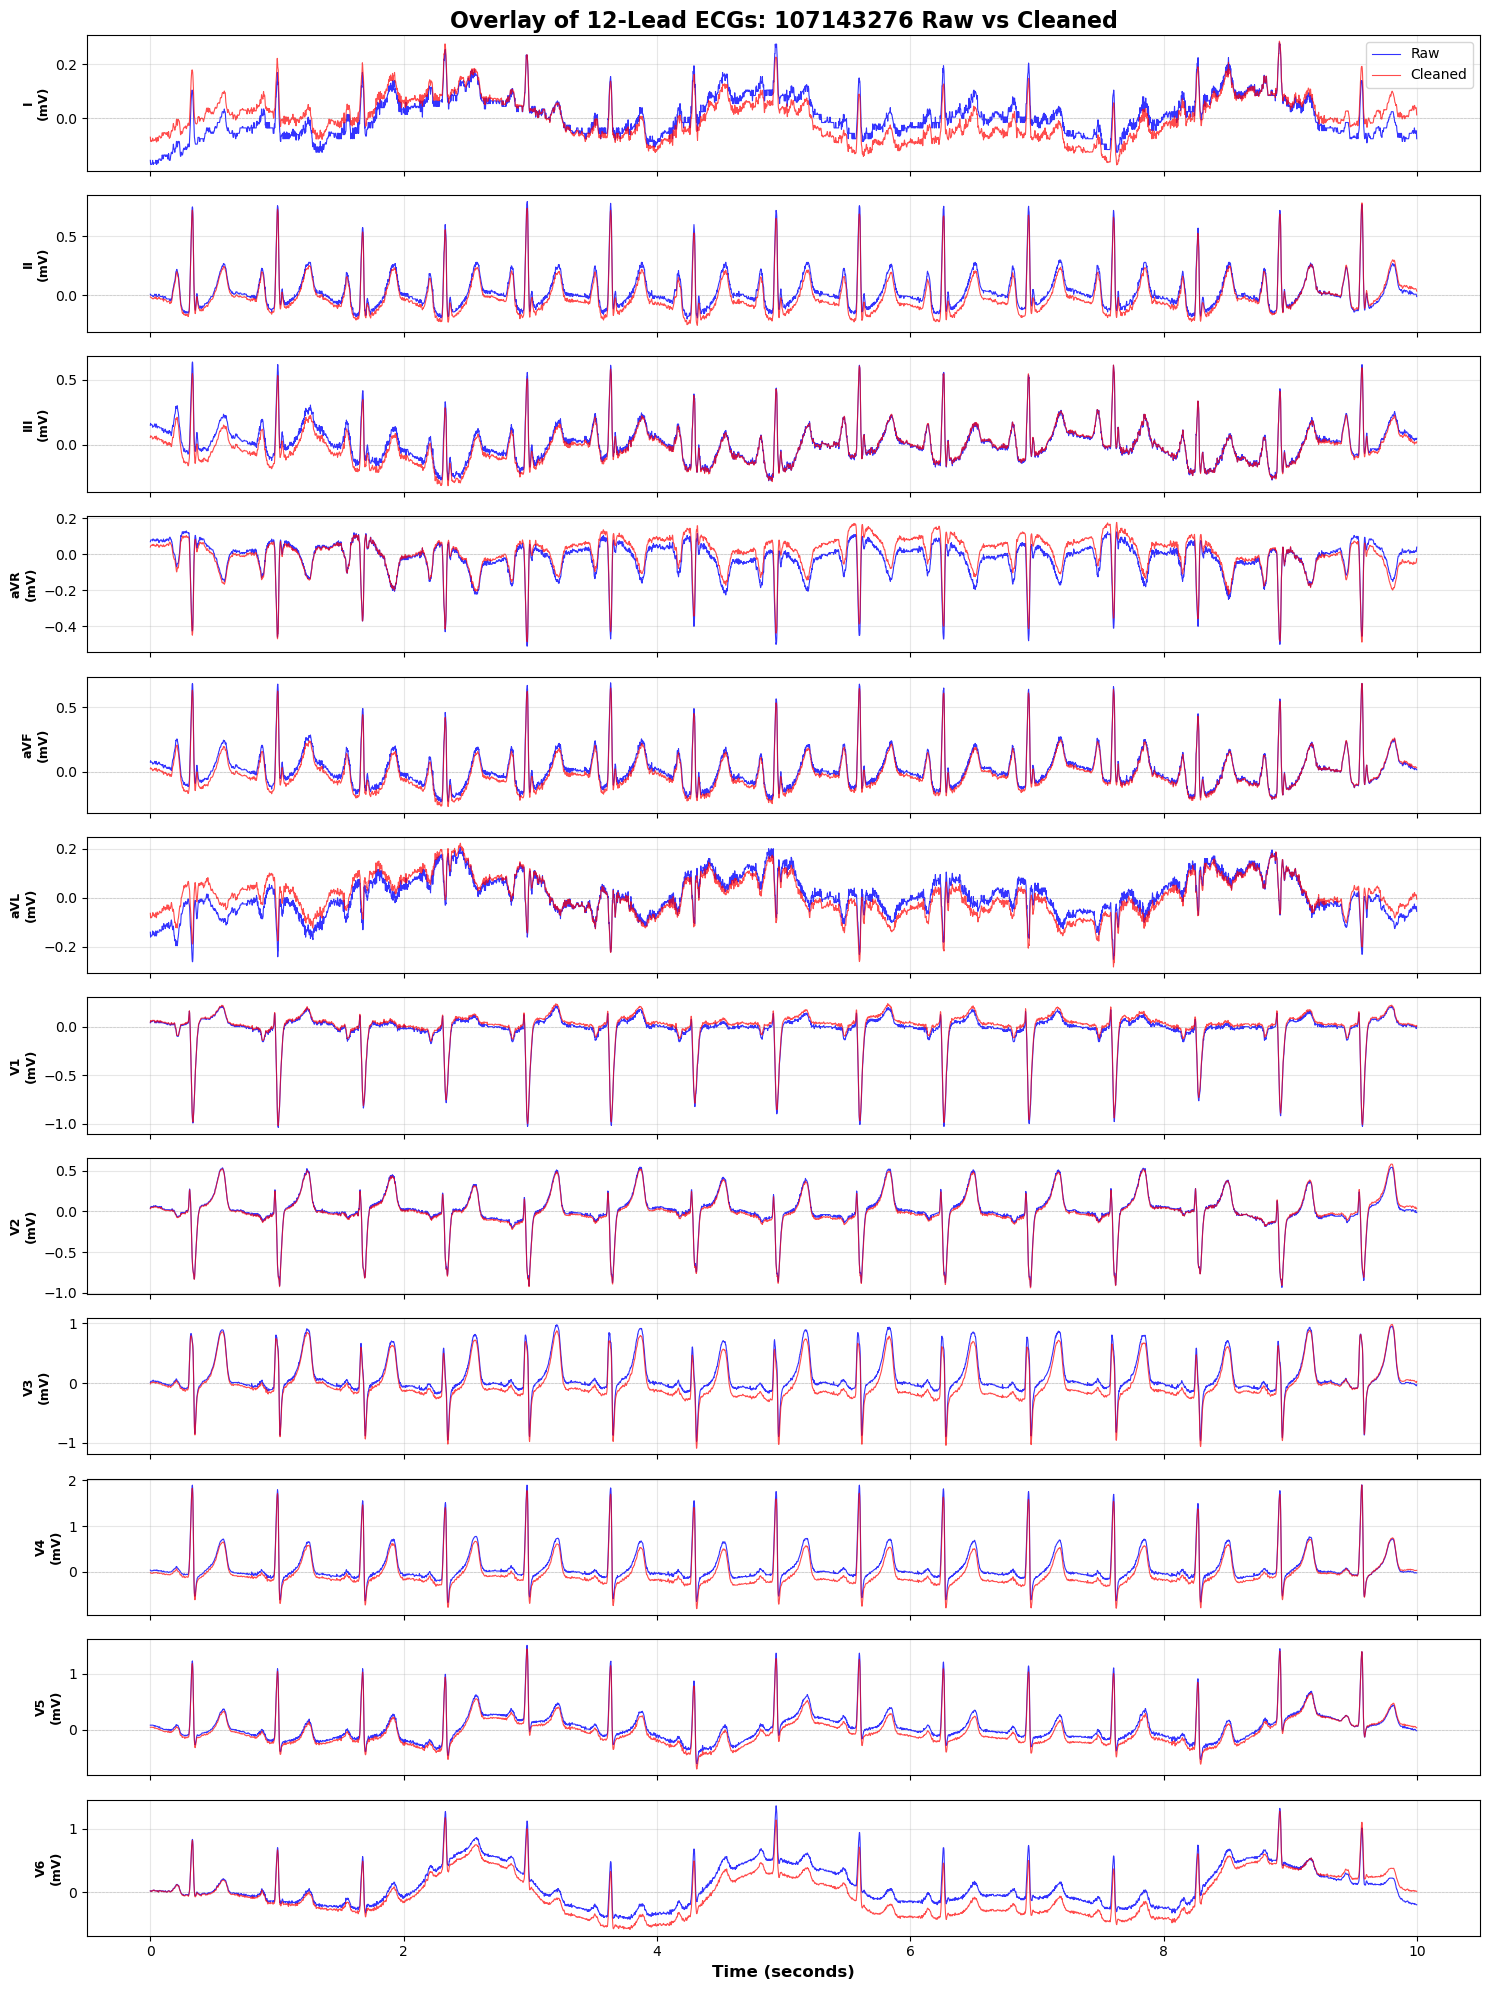

In [30]:
# Extract signals and sampling frequency
signals1 = record.p_signal
signals2 = cleaned_record.p_signal
fs = record.fs

sig_names = record.sig_name

# Ensure both signals have the same length
min_len = min(signals1.shape[0], signals2.shape[0])
signals1 = signals1[:min_len]
signals2 = signals2[:min_len]

# Create time vector
time = np.arange(min_len) / fs

# Create figure with 12 subplots
fig, axes = plt.subplots(12, 1, figsize=(15, 20), sharex=True)

for i, (ax, name) in enumerate(zip(axes, sig_names)):
    ax.plot(time, signals1[:, i], linewidth=0.8, color='blue', label='Raw', alpha=0.8)
    ax.plot(time, signals2[:, i], linewidth=0.8, color='red', label=f'Cleaned', alpha=0.7)
    
    ax.set_ylabel(f'{name}\n(mV)', fontsize=9, fontweight='bold')
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)    
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# Title, legend, and layout
axes[0].set_title(
    f'Overlay of 12-Lead ECGs: {record.record_name} Raw vs Cleaned',
    fontsize=16, fontweight='bold', pad=5
)
axes[-1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()